**Importar as Bibliotecas necessárias para análise de dados**

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

**Atribuição de métodos necessários para a manipulação de listas, um que calcula a média móvel e um que encontra um padrão qualquer desejado**

In [14]:
class Lista:
    """Lista de elementos iteráveis"""
    
    def __init__(self, l):
        self.l = list(l)
    
    def media_movel(self, pas = 3):
        """pas é o tamanho dos clusteres em que
        a Lista será divida"""
        
        temp = []
        for ix in range(len(self.l)):
            el = self.l[ix:(ix+pas)]
            if (len(el)==pas):
                temp.append(np.mean(el))

        return temp
    
    def pos (self, pat):
        """pat é o padrão que se deseja encontrar"""
        
        new_lis = []
        n = 0
        for elem in self.l:
            if elem==pat:
                new_lis.append(n)
            n+=1
        return new_lis

**Importar para um dataframe o arquivo de dados adquiridos pelo scrpit do cliente de requisições paralelas. A coluna *sim_reqs* representa o númendo de requisições simulâneas em cada passo, *taxa_sucesso* é a razão entre o número de respostas recebidas pela servidor e o número de requisições enviadas, *tempo_decorr* é o tempo gasta para enviar e receber as requisições bem-sucedida. Segue o quadro:**

In [15]:
df = pd.read_pickle(r"\requests_dataframe.pkl") #dataframe instanciado a partir dos arquivos exportados
df

,sim_reqs,taxa_sucesso,tempo_decorr
0,1,1.00,0.407925
1,1,1.00,0.124418
2,1,1.00,0.183790
3,1,1.00,0.117032
4,1,1.00,0.182043
...,...,...,...
495,100,0.25,21.088424
496,100,0.26,21.085087
497,100,0.25,21.092524
498,100,0.25,21.095177


**Agrupando os dados por quantidade de requisições simultâneas, e aplicando a média entre eles:**

In [16]:
df2 = df.groupby("sim_reqs").mean()
df2

,taxa_sucesso,tempo_decorr
sim_reqs,,
1,1.000000,0.203042
2,1.000000,0.312658
3,1.000000,0.463166
4,1.000000,0.714459
5,1.000000,0.735868
...,...,...
96,0.266667,21.107518
97,0.259794,21.095862
98,0.257143,21.109170


**A evolução do tempo de decorrido em função do número de requisições simultâneas fica:**

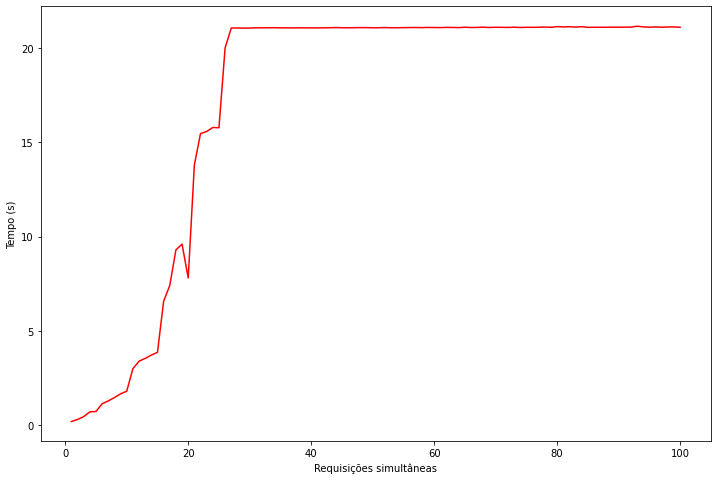

In [29]:
plt.figure(figsize=(12,8))
plt.ylabel('Tempo (s)')
plt.xlabel('Requisições simultâneas')
plt.plot(df2["tempo_decorr"],'r')

**O platô pode ser explicado pela taxa de sucesso decair a partir de 26 requisições simultâneas:**

In [31]:
df2["taxa_sucesso"][20:30]

sim_reqs
21    1.000000
22    1.000000
23    1.000000
24    1.000000
25    1.000000
26    0.969231
27    0.896296
28    0.892857
29    0.882759
30    0.786667
Name: taxa_sucesso, dtype: float64

**O que significa que o servidor são está lidando com tantas requisições simultâneas, e algumas respostas não estão sendo enviadas ao cliente:**

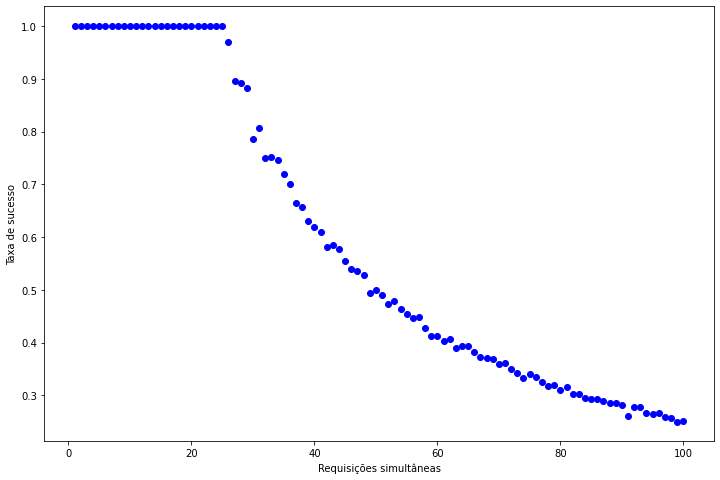

In [42]:
plt.figure(figsize=(12,8))
plt.ylabel('Taxa de sucesso')
plt.xlabel('Requisições simultâneas')
plt.plot(df2["taxa_sucesso"],'bo')

**O arquivo *ws_pcap.csv* contem uma tabela de valores exportados coletados pelo wireshark do conjunto de conversas entre cliente e servidor, filtradas para o protocolo HTTP. Estão ordenadas com relação aos pedidos e respostas relacioados, e ao longo do tempo. Estes dados podem ser lidos como:**

In [43]:
pcap = pd.read_csv(r"\ws_pcap.csv")
pcap['Resp'] = list(map(lambda el: el[:4], pcap['Info'])) #insere uma coluna "Resp" apenas com o nome do método para facilitar a análise
pcap.head()

,No.,Time,Source,Destination,Protocol,Length,Info,Resp
0,108,8.992943,192.168.100.72,192.168.100.70,HTTP,185,GET /33 HTTP/1.1,GET
1,136,9.298871,192.168.100.70,192.168.100.72,HTTP,584,HTTP/1.1 200 OK (text/html),HTTP
2,142,9.309762,192.168.100.72,192.168.100.70,HTTP,185,GET /42 HTTP/1.1,GET
3,159,9.425519,192.168.100.70,192.168.100.72,HTTP,584,HTTP/1.1 200 OK (text/html),HTTP
4,165,9.438645,192.168.100.72,192.168.100.70,HTTP,185,GET /68 HTTP/1.1,GET


**O intervalo de tempo entre requisições e respostas consecutivas pode ter sua evolução observada no seguinte gráfico:**

In [8]:
#mapeia as posições onde estão os GET e 200OK e cria uma lista com os intervalos de tempo entre eles

lista_resp = Lista(pcap['Resp'])

listg = lista_resp.pos('GET ')
listh = lista_resp.pos('HTTP')
listg = listg[:len(listh)]

tg = np.array(list (map(lambda t: pcap['Time'][t], listg)))
th = np.array(list (map(lambda t: pcap['Time'][t], listh)))

difs = []
for i in range(len(tg)):
    difs.append(th[i]-tg[i])

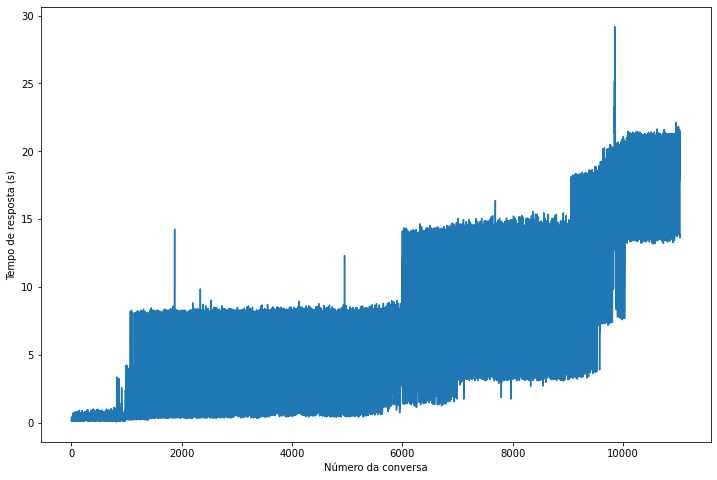

In [45]:
plt.figure(figsize=(12,8))
plt.ylabel('Tempo de resposta (s)')
plt.xlabel('Número da conversa')
plt.plot(difs)

**Sendo que, naturalmente, o número de requisições simultâneas cresce ao longo do número que ordena a conversa ao longo tempo. Representando uma linha de média móvel para cada 100 conversas, de modo a suavizar a curva, pode-se verificar melhor como o tempo de resposta almenta quando o número de requisições simultâneas também aumenta:**

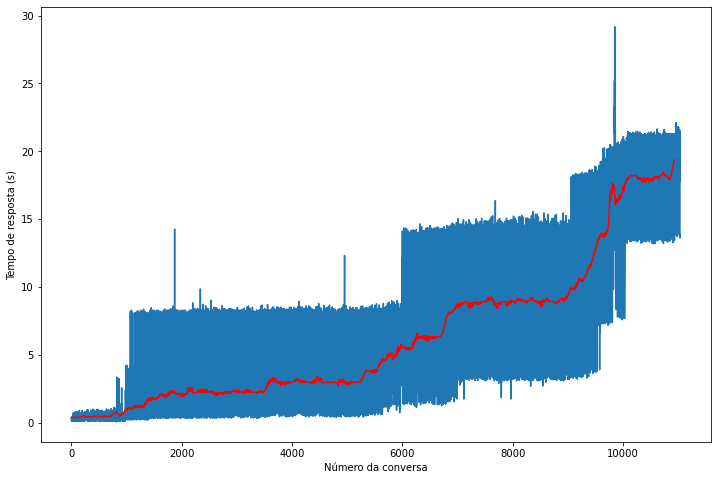

In [47]:
plt.figure(figsize=(12,8))
plt.ylabel('Tempo de resposta (s)')
plt.xlabel('Número da conversa')
plt.plot(difs)
plt.plot(Lista(difs).media_movel(100),'r')

 **De fato, pelo sniffing feito pelo WireShark, fica difícil encontrar exatamente quantas requisições simultâneas estão relacionadas a quais número de conversa, mas é evidente que o tempo de resposta aumenta, até um instante tal que as conversas ficam incompletas, há perda de pacotes, o timeout se excede e o enfileiramento excede a capacidade de comunicação com o servior. Porém, foi possível observar que a capacidade de o servidor lidar fica em torno de 25 requisições simulâneas e paralelas.**